<div style="text-align:center">Thea Kannenberg, Anastasia August<br>
KIT, Institut für Angewandte Materialien (IAM)<br>
Mikrostrukturmodellierung und Simulation (MMS)
</div>
<h1>Mikrostruktursimulation <br/>Rechnerübung Implementierung der Phasenfeldmethode WS 24/25</h1>

Im ersten Teil dieser Übung wird eine einfache Formulierung der eindimensionalen Phasenfeldgleichung mit Hilfe von finiten Differenzen implementiert. Aufbauend auf der Implementierung wird der Einfluss der Parameter untersucht.

Im zweiten Teil ist die zweidimensionale Implementierung schon gegeben und es soll der Einfluss der Parameter bestimmt werden und mit den Ergebnissen aus einer Dimension verglichen werden. Weiterhin wird überprüft, ob der theoretisch bestimmbare kritische Keimradius mit der Phasenfeldmethode korrekt bestimmt werden kann. Zuletzt wird die Phasenfeldmethode noch zur Untersuchung von Kornwachstum in einer stark vereinfachten Geometrie benutzt.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from math import ceil, floor
import sympy as sp
import numpy as np
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = (7,4)
mpl.rcParams['axes.grid'] = True
import time
from numba import jit
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
testfield = np.linspace(0, 1, 10)**3
correct_laplace = np.array([0.        , 0.00823045, 0.01646091, 0.02469136, 0.03292181,
       0.04115226, 0.04938272, 0.05761317, 0.06584362, 0.        ])
correct_a = np.array([0.        , 0.08230453, 0.16460905, 0.24691358, 0.32921811,
       0.41152263, 0.49382716, 0.57613169, 0.65843621, 0.        ])
correct_w = np.array([ 0.        ,  0.00491797,  0.03821507,  0.11888432,  0.23768184,
        0.33604882,  0.30580704,  0.05290172, -0.30455913,  0.        ])
correct_f = np.array([0.        , 0.00032877, 0.00260484, 0.00855967, 0.0192202 ,
       0.03409598, 0.05004115, 0.05979125, 0.05017483, 0.        ])


def tester(testfunc, testfield, correct):
    fncname = testfunc.__name__
    if fncname == "f":
        vals = testfunc(testfield, 0.98)
    else:
        vals = testfunc(testfield)
    diff = np.sum(np.abs(vals - correct))
    if diff < 1e-6:
        print(fncname + " works")
        return True
    else:
        print(fncname + " doesn't work")
        return False
# Randbedingungen
def neumannzero(field):
    field[0] = field[1]
    field[-1] = field[-2]
    
def periodic(field):
    field[0] = field[-2]
    field[-1] = field[1]

## Aufgabe 1: 1D-Phasenfeldgleichung ##

In dieser Aufgabe soll die 1D-Phasenfeldgleichung

$
\begin{align}
\tau \epsilon \frac{\partial \phi}{\partial t} &= a(\phi) - w(\phi) + f(\phi, T)\\
a(\phi) &= 2\sigma\epsilon \bigtriangleup \phi = 2\sigma\epsilon \frac{\partial^2\phi}{\partial x^2}\\
w(\phi) &= \frac{18\sigma}{\epsilon}(2\phi^3 - 3\phi^2 + \phi)\\
f(\phi,T) &= 6L_\alpha \frac{T_m - T}{T_m}(\phi-\phi^2)
\end{align}
$

implementiert werden. Es wird angenommen, dass die Temperatur $T$ im Gebiet konstant ist. Die Simulationsparameter sind in der nächsten Zelle definiert.

In [3]:
deltax = 1
T = 1.0
sigma = 1.0
tau = 5.0
epsilon = 5 * deltax
T_m = 1.0
L_a = 2
deltat = 0.5 * sigma / tau * (1 / deltax)**2 
physlen = 1 * 80
numx=int(physlen / deltax)


### 1a) Evolutionsterme  ###
Implementieren Sie die Terme $a$, $w$ und $f$ aus der Phasenfeldgleichung. Für die Berechnung von $a$ wird die zweite Ableitung (Laplace) des Ordnungsparameterfelds $\phi$ benötigt; nutzen Sie zentrale finite Differenzen zweiter Ordnung für die Berechnung dessen.

Das $\phi$-Argument für a, w, f entspricht einem ganzen Feld (Array) und diese geben auch ganze Felder wieder zurück. Sie können dies über das sog. broadcasting von numpy bequem lösen, indem Sie mit dem ganzen Feld auf einmal rechnen, siehe die nächste Zelle für ein Beispiel.

Der Laplace soll jedoch mit einer Schleife über das Feld berechnet werden.

**Hinweis**: Sie können einzelne Funktionsimplementierungen mit

tester(functionname, testfield, correct_functionname)

z.B.

tester(f, testfield, correct_f)

auf Korrektheit überprüfen.

In [4]:
bsp = np.linspace(1, 10, 10) # 1 bis 10 inklusive
print(bsp) # wie gehabt
print(bsp**2) # hier wird die Operation mit jedem Element durchgeführt!

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]


In [5]:
@jit
def laplace(field):
    lapl = np.zeros_like(field)
    length = field.shape[0]
    # Schleife über alle inneren Elemente von field
    # Die räumliche Schrittweite ist als deltax abgespeichert und
    # kann hier direkt verwendet werden.
    #for i in range(2, length-2, 1): # für das Verfahren 4. Ordnung ### hide ###
    for i in range(1, length-1, 1):
        lapl[i] = \
        (field[i-1] - 2*field[i] + field[i+1]) / (deltax*deltax) ### hide ###
        # Verfahren 4. Ordnung ### hide ###
        #lapl[i] = (-1/12.0 * field[i-2] + 4.0/3.0 * field[i-1] ### hide ###
        #- 2.5 * field[i] + 4.0/3.0 * field[i+1] - 1/12.0 * field[i+2]) / (deltax * deltax) ### hide ###
    # Für das Verfahren 4. Ordnung müssen die Laplacewerte ### hide ###
    # in Zellen 1 und -2 separat berechnet werden ### hide ###
    # da das zentrale Verfahren 4. Ordnung hier auf ### hide ###
    # Werte außerhalb des Gebiets zugreifen würde. ### hide ###
    # es werden hierzu gerichtete Differenzen der 2. Ableitung von 4. Ordnung benutzt ### hide ###
    #lapl[1] = (15/4.0 * field[1] - 77/6.0 * field[2] ### hide ###
    #           + 107/6.0 * field[3] - 13 * field[4] + 61/12.0 * field[5] ### hide ###
    #          - 5/6.0 * field[6]) ### hide ###
    #lapl[-2] = (15/4.0 * field[-1] - 77/6.0 * field[-2] ### hide ###
    #           + 107/6.0 * field[-3] - 13 * field[-4] + 61/12.0 * field[-5] ### hide ###
    #          - 5/6.0 * field[-6]) ### hide ###
    return lapl 

@jit
def a(phi):
    laplacephi = laplace(phi)
    return \
    2*sigma*epsilon*laplacephi ### hide ###

@jit
def w(phi):
    return \
    18*sigma / epsilon * (2*phi**3 - 3*phi**2 + phi) ### hide ###

@jit
def f(phi, T=1.0):
    return \
    6*L_a * (T_m-T) / (T_m ) * (phi - phi**2) ### hide ###

### hide ###

In [6]:
# für die initial definierten Parameter!
tester(laplace, testfield, correct_laplace)
tester(a, testfield, correct_a)
tester(w, testfield, correct_w)
tester(f, testfield, correct_f)

laplace works
a works
w works
f works


True

### 1b) Zeitintegration ###
Implementieren Sie die Zeitintegration mit dem expliziten Eulerverfahren für die Phasenfeldgleichung.

In [7]:
@jit
def explEuler(phiold, phinew):
    length = phiold.shape[0]
    aa = a(phiold)
    ww = w(phiold)
    ff = f(phiold, T)
    for i in range(1, length-1, 1):
        phinew[i] = \
        phiold[i] + deltat * (aa[i] - ww[i] + ff[i]) / (tau * epsilon) ### hide ###
        
### hide ###

### Anfangsbedingungen ###

In [8]:
def ini(field):
    length = field.shape[0]
    field[:int(length/2)] = 1 # von Anfang bis zur Mitte 1 = fest
    field[int(length/2):] = 0 # und dahinter 0 = flüssig

### 1c) Simulation ###
Führen Sie nun die Simulation aus und beobachten Sie das Phasenfeldprofil für verschiedene Zeiten. Beschreiben Sie die Evolution des Phasenfelds.

Aus dem initialen scharfen Übergang wird ein diffuser Übergang ohne, dass sich das Interface bewegt. ### hide ###

Weiter unten unter "Visualisierung" ist der Plotbefehl für das Gleichgewichtsprofil auskommentiert. Aktivieren Sie diesen und vergleichen Sie die numerische und analytische Lösung. Beachten Sie dabei, dass das Erreichen des Gleichgewichts ein zeitabhängiger Prozess ist und damit die Variable `goaltime` angepasst werden kann.

Bis zur Simulationszeit 10 gibt es noch visuelle Unterschiede. Wird jedoch bis zur Simulationszeit 20 gerechnet gibt es visuell fast keine Unterschiede mehr, d.h. die numerische Lösung nähert die analytische Lösung gut an. ### hide ###

Wie könnte die analytische Lösung im Gleichgewicht besser getroffen werden?

Der Unterschied beruht auf Fehlern, die beim numerischen Lösen der PDE entstehen. Da die Gleichgewichtslösung dem stationären Zustand entspricht ($\frac{\partial \phi}{\partial t} = 0$), spielt die Zeitintegration nur insofern eine Rolle, ob diese zu einem stationären Zustand konvergiert, was für eine stabile Zeitschrittweite der Fall ist. Insofern muss die Genauigkeit der örtlichen Diskretisierung erhöht werden, was z.B. über eine höhere Gitterauflösung (mehr Zellen, `numx`) oder mit einem Verfahren höherer Ordnung für den Laplace realisiert werden kann. In der Lösung ist für den Laplace zusätzlich ein Verfahren 4. Ordnung implementiert, welches einen geringere Abweichung von der analytischen Lösung zeigt, vgl. hierzu die Berechnung der $L^2$-Norm. ### hide ###

In [9]:
# Parameter zur Variation. 
tau = 1
epsilon = 5
sigma = 0.5
T = 1

numx = 42 # deltax wird über die Zahl der Zellen numx gesteuert
physlen = 80
deltax= physlen/(numx-2)
deltat = 0.05 * 1 / (2*1)  * (deltax**2)
#deltat = 0.05 * tau / (2*sigma)  * (deltax**2) ### hide this line ### 

# Initialisierung der Felder
phiold = np.zeros(numx)
phinew = np.zeros(numx)
ini(phiold)
framelist = []
times = []
t=0
# Über <funktion>.recompile werden die Änderungen an T/tau/epsilon den Funktionen sichtbar gemacht.
laplace.recompile()
a.recompile()
w.recompile()
f.recompile()
explEuler.recompile()

In [10]:
goaltime = 10
timesteps= int(goaltime / deltat)
writefreq= int(timesteps / 20)

neumannzero(phiold)
start = time.time()
for i in range(timesteps):
    if i%writefreq == 0:
        framelist.append(phiold.copy())
        times.append(t)
        
    explEuler(phiold, phinew)
    neumannzero(phinew)
    # swap new and old field
    phiold, phinew = phinew, phiold
    t+=deltat
framelist.append(phiold.copy())
times.append(t)
end = time.time()
print("Laufzeit: %f Sekunden" % (end-start))
framecount = len(framelist)

Laufzeit: 0.189206 Sekunden


In [11]:
# Physikalische Koordinaten
p1 = -deltax * 0.5
p2 = p1 + physlen + deltax
xx = np.linspace(p1, p2, numx)
# und die analytische Lösung im Gleichgewicht (GGW), verschoben zur Gebietsmitte
phi_eq = 0.5 * (1 - np.tanh(1.5 * (xx-(physlen)/2) / epsilon))

In [12]:
# L^2-Norm für die Abweichung der analytischen zur numerischen Lösung: kleiner = besser
np.sqrt(np.sum( (phi_eq - framelist[-1])**2)*deltax)

0.05117137993570792

# Visualisierung

<IPython.core.display.Javascript object>


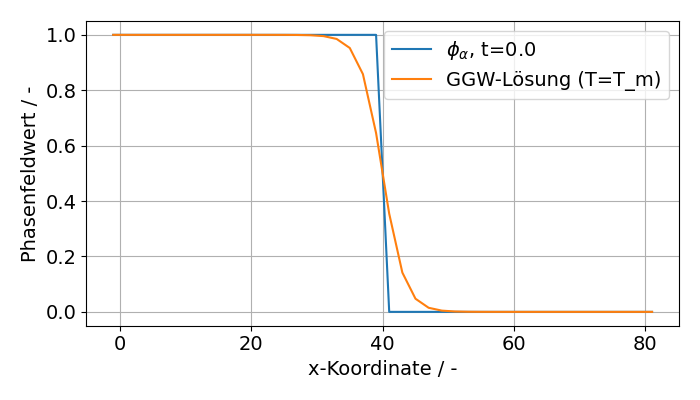

In [13]:

fig, ax = plt.subplots()

linephi, = ax.plot(xx, framelist[0], label=r"$\phi_\alpha$, t=0", )
ax.plot(xx, phi_eq, label="GGW-Lösung (T=T_m)")


ax.set_xlabel("x-Koordinate / -")
ax.set_ylabel("Phasenfeldwert / -")
ax.legend(loc='upper right')
fig.canvas.draw()
fig.tight_layout()


def plotter(frame):
    frame = frame -1
    linephi.set_ydata(framelist[int(frame)])
    linephi.set_label(r"$\phi_\alpha$, t=%.1f" % (times[int(frame)]))
    fig.canvas.draw()
    ax.legend(loc='upper right')

In [14]:
interact(plotter, frame=widgets.IntSlider(min=1, max=framecount, step=1, value=1))

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.plotter(frame)>

### 1d) Parametervariation ###
Wie verändert sich das Simulationsergebnis, wenn Sie die Parameter $\epsilon$, $\sigma$ und $\tau$ variieren? Ändern Sie hierzu die vorgegeben Parameter in der Zelle mit "Parameter zur Variation." und führen Sie diese Zellen und die nachfolgenden bis zur Visualisierung aus.

Beispiele: $\epsilon=10$, $\sigma=1.0$, $\tau=10.0$


Der Parameter $\epsilon$ bestimmt die Interfacebreite und damit auch das Gleichgewichtsprofil. $\tau$ und $\sigma$ hingegen kontrollieren wie schnell sich das Interface einstellt. Auf das Gleichgewichtsprofil haben diese jedoch keinen Einfluss. ### hide ###

### 1e) Treibende Kraft
Bisher lag keine treibende Kraft für die Phasenumwandlung vor, da die Temperatur $T$ der Schmelztemperatur $T_m$ entsprach. Ändern Sie diese wie $\epsilon$ und $\tau$ und beschreiben Sie, wie sich das Simulationsergebnis ändert.

Beispiele: $T=0.5$, $T=1.5$

Die Temperatur bestimmt die Größe und Richtung der treibenden Kraft. Die treibende Kraft bestimmt, in welche Richtung sich das Interace bewegt. Bei Temperaturen unterhalb des Schmelzpunkts wächst die feste Phase, während darüber die flüssige Phase wächst. ### hide ####

## Aufgabe 2: 2D-Phasenfeldgleichung ##
In dieser Aufgabe ist die 2D-Phasenfeldgleichung schon implementiert. 

### 2a) Parametervariation ###
Untersuchen Sie den Einfluss der Parameter ($\tau$, $\epsilon$, $\sigma$), indem Sie die Werte in der folgenden Zelle ändern und die Simulation starten. Beschreiben und erklären Sie die Evolution des Phasenfeldes. Gehen Sie insbesondere auf die Zeit bis zum Verschwinden des Keims ein und wie sich die Einflüsse von $\tau$ und $\sigma$ unterscheiden.

**Hinweis:** Die Zeit bis zum Verschwinden des Keims wird direkt nach der Berechnung ausgegeben.

Auch hier wird der initiale scharfe Übergang zunächst diffus. Weiterhin schrumpft der Kreis aufgrund der Kapillarkräfte. $\tau$ wie auch $\epsilon$ beeinflussen die Simulation wie in 1D. $\sigma$ beeinflusst ebenso die Geschwindigkeit, mit der der Kreis wegschrumpft. Dies kommt einerseits über den Effekt wie in 1D einher, da $\frac{\sigma}{\tau}$ die effektive Diffusivität des Phasenfelds darstellt und damit wie schnell sich dieses einstellt. Weiterhin beeinflusst $\sigma$ im Gegensatz zu $\tau$ aber auch die Kapillarkräfte, weshalb eine Variation von $\sigma$ einen größeren Einfluss auf die Zeit bis zum Verschwinden hat als eine äquivalente Variation von $\tau$. ### hide ###

In [ ]:
deltaX=1
deltaY=1
T_m=1
#T=0.75


L_a=0.5
NumX=101 
NumY=101


In [ ]:
@jit
def ini_rectangle(field, ulc_x, ulc_y, w, h):
    # Setzen des Anfangsfillings: Rechteck mit Angabe des oberen linken Eckes + Breite, Höhe
    for i in range(ulc_x, ulc_x + w):
        for j in range(ulc_y, ulc_y + h):
            field[i][j]= 1

@jit            
def ini_circle(field, cx, cy, r):
    # Setzen des Anfangsfillings: Kreis
    nx2 = int(cx) 
    ny2 = int(cy) 
    for i in range(nx2 - r, nx2 + r + 1):
        for j in range(ny2 - r, ny2 + r + 1):
            if (i-nx2)**2 + (j-ny2)**2 <= r**2:
                field[i][j]= 1            


@jit
def bcs(field):
    #Randbedingungen (Neumann-Null-Rand)
    for i in range(0, NumX):
        field[i][0]=field[i][1]
        field[i][NumY-1]=field[i][NumY-2]
     
    for i in range(0, NumY):
        field[0][i]=field[1][i]
        field[NumX-1][i]=field[NumX-2][i]
    
@jit
def calc_phi(phi_old, phi_new):
    phisum = 0
    for i in range(1, NumX-1):
        for j in range(1, NumY-1):

            a_x=2*sigma*(phi_old[i+1][j]
                         -2*phi_old[i][j]
                         +phi_old[i-1][j])/(deltaX**2)
            a_y=2*sigma*(phi_old[i][j+1]
                         -2*phi_old[i][j]
                         +phi_old[i][j-1])/(deltaY**2)
            w=-18/(epsilon**2)*sigma*(
                2*phi_old[i][j]**3
                -3*phi_old[i][j]**2
                +phi_old[i][j])
            L=L_a*(T_m-T)/T_m
            f=L/epsilon*6*(phi_old[i][j]-phi_old[i][j]**2)

            phi_new[i][j]=phi_old[i][j]+ deltat/tau *(a_x+a_y+w+f)
            phisum += phi_new[i][j]
    return phisum

In [ ]:
# Parametervariation
T=T_m-0.0 # Unterkühlung von 0.01
sigma=1
tau=4
epsilon=4
deltat=min(deltaX, deltaY)**2 * tau / (8 * 2 * sigma)
calc_phi.recompile()
print(deltat)

In [ ]:
# Anlegen des Gebietes (aktueller und neuer Zeitschritt)
phi_new  = np.zeros((NumX,NumY))
phi_old  = np.zeros((NumX,NumY))
radius=20
# Geometrie 1: Nur ein fester Keim in der Mitte des Gebiets
ini_circle(phi_old, NumX/2, NumY/2, radius)
# Geometrie 2: Die obere Hälfte des Gebiets ist fest, die untere flüssig; ini_circle darüber auskommentieren
#ini_rectangle(phi_old, 0,0, int(NumX/2), NumY)
# Geometrie 3: Beide Geometrien zusammen aufstellen.
framelist2d=[]
phisums=[]
times2d=[]
t2d=0
time2vanish = np.nan

In [ ]:
timesteps=5000
writefreq=250
bcs(phi_old)
start = time.time()
phisum = np.sum(phi_old)
for i in range(timesteps):
    if i%writefreq == 0:
        framelist2d.append(phi_old.copy())
        times2d.append(t2d)
        phisums.append(phisum)
    phisum = calc_phi(phi_old, phi_new)
    bcs(phi_new)
    phi_old, phi_new = phi_new, phi_old
    t2d += deltat
    if (phisum < 1e-5*NumX*NumY and np.isnan(time2vanish)):
        time2vanish = t2d

framelist2d.append(phi_old.copy())
times2d.append(t2d)
phisums.append(phisum)

end = time.time()
print("Laufzeit: %f Sekunden" % (end-start))
framecount2d = len(framelist2d) - 1 
if not np.isnan(time2vanish):
    print("Zeit bis zum Verschwinden: %f" % ( time2vanish))
else:
    print("Keim noch nicht verschwunden.")

In [ ]:
fig2d, ax2d = plt.subplots()
im = ax2d.imshow(framelist2d[0], vmin=0, vmax=1)
fig2d.colorbar(im)
fig2d.canvas.draw()
ax2d.set_title("t=%.2f" % times2d[0])
ax2d.grid(False)
fig2d.tight_layout()

def plotter2d(frame):
    frame = frame -1
    ax2d.clear()
    im = ax2d.imshow(framelist2d[int(frame)], vmin=0, vmax=1)
    ax2d.set_title("t=%.2f" % times2d[int(frame)])
    ax2d.grid(False)
    fig2d.canvas.draw()

    
#interact(plotter2d, frame=widgets.BoundedFloatText(min=0, max=framecount2d, step=1, value=0))

In [ ]:
interact(plotter2d, frame=widgets.BoundedIntText(min=1, max=framecount2d, step=1, value=1))

In [ ]:
rs = np.sqrt(np.array(phisums) / np.pi)
times2dd = np.array(times2d)
fig, ax = plt.subplots()
ax.plot(times2dd, rs)
ax.set_xlabel("Simulationszeit / -")
ax.set_ylabel("Keimradius / -")
fig.tight_layout()

### 2b) Einfluss der Kapillarität
Im Gegensatz zum 1D-Fall gibt es in höheren Dimensionen eine treibende Kraft durch Oberflächenspannung. Wie groß muss die Unterkühlung $\Delta T = T_m - T$ sein, dass diese die Kapillarkraft ausgleicht und somit der Keim sich in einem instabilen Gleichgewicht befindet?

**Hinweis**: Stellen Sie die Gesamtenergie des 2D-Systems bestehend aus dem Beitrag für Phasenumwandlung ($G_A = L_\alpha \frac{\Delta T}{T_m}$) und dem der Kapillarität ($G_U = \sigma$) auf. Beide Beiträge werden von der Geometrie über den Radius $r$ beeinflusst. Die Lösung davon lässt sich von Hand wie auch mit sympy symbolisch bestimmen.

Die kritische Unterkühlung lässt sich wie unten gezeigt herleiten, indem die Gesamtenergie nach dem Radius abgeleitet und gleich Null gesetzt wird. Setzt man diese Unterkühlung, so ist der Keim jedoch noch in geringem Maße am Schrumpfen. Dies ist einerseits bedingt durch die scharfen Anfangsbedingungen, die nicht exakt einem Kreis mit Radius $r$ entsprechen, und andererseits auch durch numerische Fehler bedingt. Dies ist in der Berechnung nicht berücksichtigt worden. ### hide ###

In [ ]:
import sympy as sp
sp.init_printing()

In [ ]:
dT = sp.symbols("dT")
Tm = sp.symbols("T_m")
r = sp.symbols("r")
sigmasym = sp.symbols("sigma")
La = sp.symbols("L_\\alpha")

In [ ]:
A = math.pi * r**2 ### hide ###
U = 2*math.pi*r ### hide ###
G_A = La * dT/Tm
G_U = sigmasym
G_A_int =  G_A * A ### hide ###
G_U_int = G_U * U ### hide ###

In [ ]:
G_total = -G_A_int + G_U_int  ### hide ###

In [ ]:
display(G_total) ### hide ###

In [ ]:
dG = sp.diff(G_total,r) ### hide ###
dT_eq = sp.solve(dG, dT)[0] ### hide ###
display(dT_eq) ### hide ###

In [ ]:
print(T_m, radius, sigma, L_a) # radius=10 und diskret: 10.045109950630787 ### hide ###

In [ ]:
print("Kritische Unterkühlung: %f" % (dT_eq.subs({Tm:T_m, r: radius, sigmasym: sigma, La: L_a}))) ### hide ###

### 2c) Geometrievariation
Bei 2a) unter "Anlegen des Gebietes (aktueller und neuer Zeitschritt)" sind drei verschiedene Geometrien definiert, von denen Sie soweit die Geometrie 1 untersucht haben. Setzen Sie die entsprechenden Geometrien und diskutieren Sie die Ergebnisse in Hinblick auf die Unterschiede zwischen Simulationen in einer und mehreren Dimensionen.

Bei Geometrie 2 wird eine planare Grenzfläche gesetzt. Dies entspricht einer 1D-Phasenfeldgleichung für jeden Punkt darauf, da die Ableitung quer zum Interface überall 0 beträgt. ### hide ###

Bei Geometrie 3 bildet sich der Halbkreis auf der planaren Grenzfläche zurück. Dies ist bedingt durch den Einfluss der Kapillarität in zwei Dimensionen. Nachdem die Grenzfläche nur noch planar ist entspricht das Verhalten dem der zweiten Geometrie. ### hide ###


### 2d) Kornwachstum
Das aktuelle Modell kann für $T=T_m$ auch zur Modellierung von Kornwachstum genutzt werden, da damit die treibenden Kräfte bis auf die Kapillarität verschwinden. Ein einfaches Modell für die Evolution einer gekrümmten Fläche lässt sich als

$
\begin{align}
v = \frac{dr}{dt} &= MF \\
F = -\gamma\kappa &= -\frac{\gamma}{r}\\
\frac{dr}{dt}  &= -\frac{M\gamma}{r}\\
\end{align}
$

schreiben, mit der Geschwindigkeit der Grenzfläche $v$, der Mobilität $M$, der treibenden Kraft $F$ durch Kapillarität, der Oberflächenenergie $\gamma$ und der Krümmung $\kappa$, welches sich für einen Kreis als das Inverse des Radius' $r$ berechnen lässt. 

Lösen Sie zunächst die Differentialgleichung mit Separation der Variablen oder sympy (`sp.dsolve`), um auf einen expliziten Ausdruck für den Kornradius $r(t)$ zu gelangen. Vergleichen Sie anschließend den Ausdruck mit den Daten aus der Simulation, indem Sie für $M = \frac{2}{\tau}$ und $\gamma = \sigma$ annehmen. In der folgenden Zellen sind schon Plotkommandos vorbereitet, in denen Sie nur die Ausdrücke korrekt einsetzen müssen.

Stimmen Simulation und das einfache Modell überein? Kann hiermit Kornwachstum bei beliebiger Korngröße modelliert bzw. simuliert werden?

Modell und Simulation stimmen größtenteils überein, mit der restlichen Abweichung aufgrund von diskreten Anfangsbedingungen sowie Diskretisierungsfehlern. Prinzipiell lassen sich sowohl mit dem Modell wie der Simulation nun Vorhersagen für beliebige Korngrößen treffen, sofern die Bewegungsgleichungen tatsächlich einer einfachen Krümmungsminimierung entsprechen. ### hide ###


Bonusfrage: Um Kornwachstum repräsentativ zu simulieren ist eine große Zahl von Körnern $\gg 1000$ nötig. Wie würde diese Bedingung das Phasenfeldmodell ändern? ### hide ###

Es gibt zwei Ansätze, um diesem Problem zu lösen:  ### hide ###

Einerseits kann man für jedes Korn ein eigenes Phasenfeld einführen und die Energien dieser einzelnen Phasenfelder koppeln. Das bedingt aber bei einer naiven Implementation eine Explosion der Freiheitsgrade, da nun pro Gitterpunkt so viele Gleichungen wie Körner vorliegen. Dies kann man umgehen, indem etwa lokal nur eine fixe Zahl an Phasenfelder erlaubt sind oder ein örtliches Neuzuweisen von Phasenfeldern durchgeführt wird. ### hide ###

Andererseits kann auch die physikalische Information des Übergangs zusätzlich abgebildet werden, nämlich die Kornorientierung. Dies bedingt dann mehrere Evolutionsgleichungen für die Kornorientierung, die gleichzeitig die Korngrenzenergien abbilden müssen. ### hide ###



In [ ]:
## Lösung mit sympy; die Lösung auch kann von Hand über Separation der Variablen gefunden werden
## es muss nur eine von beiden Varianten umgesetzt werden und in der nächsten Zelle eingefügt werden.
t, M, gamma, F = sp.symbols("t M gamma F")
R0 = sp.symbols("R_0")
r = sp.Function("r")
ode = sp.diff(r(t), t)+M*gamma/r(t)
sol = 0+\
    sp.dsolve(ode, ics={r(0): R0}).rhs ### hide this line ###
try:
    # aus dsolve kommt ein Gleichung heraus => rechte Seite mit dsolve().rhs nehmen!
    sp.printing.pprint(sol)
    solfunc = sp.lambdify((M, gamma, R0, t), sol)
except Exception as e:
    print(e)

In [ ]:
fig, ax = plt.subplots()
filt = rs > 1 # Filter um den Endbereich abzutrennen
# Benutzen Sie rs0 und t0 als Eingabedaten!
rs0 = rs[filt]
t0 = times2dd[filt]
xdata = t0
ydata_sim = rs0 
Mgamma = 2*sigma/tau

ax.plot(xdata, ydata_sim, label="Simulation")
try:
    # falls Sie die Lösung von Hand bestimmt haben,
    # schreiben Sie diese in ydata_model anstatt 0
    ydata_model = 0\
    +np.sqrt(rs0[0]**2 -2*Mgamma*(t0-t0[0])) ### hide this line ###
    ax.plot(xdata, ydata_model, label = "Modell")
except Exception as e:
    print(e, "model missing")
try:
    ydata_sympy = solfunc(2/tau, sigma, rs0[0], xdata)
    ax.plot(xdata, ydata_sympy, label="Modell via sympy")
except Exception as e:
    print(e, "sympy missing")


ax.set_xlabel("Zeit / -")
ax.set_ylabel("Kornradius / Zellen")
ax.legend()
fig.tight_layout()